In [71]:
import numpy as np
import copy 
import time
import random
import math

In [72]:
def str_arr(arr):
    strng = ""
    for obj in arr: 
        if type(obj) is type(""):
            strng += obj + " "   
        else:
            strng += "%.5f" % obj + " "
    return strng

In [289]:
# Numpy version of the BitTensor attribution an emmission calculation.


# # # Out-loop weights.
# M = np.array([[0,     0.1,   0.3,   0.1,     0], 
#               [0.1,   0,     0,     0.1,     0],
#               [0.1,   0.1,   0,     0.1,     0],
#               [0.2,   0,     0.3,     0,     0.5],
#               [0,     0.1,   0,     0.1,     0]])


# # In-loop weights.
# N = np.array([0.6, 
#               0.7,
#               0.4,
#               0.6,
#               0.5])


# edges = {'a': list(zip(['a', 'b', 'c', 'd'], [0.6, 0.1, 0.1, 0.2])),
#          'b': list(zip(['b', 'a', 'c', 'e'], [0.7, 0.1, 0.1, 0.1])),
#          'c': list(zip(['c', 'a', 'd'], [0.4, 0.3, 0.3])),
#          'd': list(zip(['d', 'a', 'b', 'c', 'e'], [0.6, 0.1, 0.1, 0.1, 0.1])),
#          'e': list(zip(['e', 'd'], [0.5, 0.5]))
# }


# # Out-loop weights.
M = np.array([[0,     0,   0.3,     0.2,     0], 
              [0.1,   0,     0,     0.1,     0],
              [0.1,   0,     0,     0.2,     0],
              [0.2,   0,   0.3,     0,     0],
              [0,     0,     0,     0.0,     0]])


# In-loop weights.
N = np.array([0.6, 
              1.0,
              0.4,
              0.5,
              1.0])

edges = {'a': list(zip(['a', 'b', 'c', 'd'], [0.6, 0.1, 0.1, 0.2])),
         'b': list(zip(['b'], [1.0])),
         'c': list(zip(['c', 'a', 'd'], [0.4, 0.3, 0.3])),
         'd': list(zip(['d', 'a', 'b', 'c'], [0.5, 0.2, 0.1, 0.2])),
         'e': list(zip(['e'], [1.0]))
}


# Stake per node.
S = np.array([10, 
              10,
              10,
              10,
              10])


# Emmission step.
e_steps = 5
for e_step_i in range(e_steps):


    # Attribution calculation.
    A = np.multiply(S, N)
    T = np.matmul(M, S)
    
    depth = 10
    for _ in range(depth):
        A += np.multiply(T, N)
        T = np.matmul(M, T)
    A = A / np.linalg.norm(A, 1)
    
    
    # Emmision calculation.
    E = A * np.sum(S) * 0.05
    S = S + E
    
    print ('Step:', e_step_i)
    print ('S:', str_arr(S))
    print ('A:', str_arr(A))
    print ('E:', str_arr(E))
    print ('------------------')




Step: 0
S: 10.54928 10.68310 10.30986 10.45774 10.50002 
A: 0.21971 0.27324 0.12394 0.18309 0.20001 
E: 0.54928 0.68310 0.30986 0.45774 0.50002 
------------------
Step: 1
S: 11.12487 11.40874 10.63086 10.93548 11.02505 
A: 0.21927 0.27643 0.12229 0.18200 0.20001 
E: 0.57558 0.72564 0.32101 0.47774 0.52503 
------------------
Step: 2
S: 11.72794 12.17942 10.96346 11.43410 11.57633 
A: 0.21880 0.27961 0.12067 0.18090 0.20001 
E: 0.60308 0.77068 0.33260 0.49862 0.55128 
------------------
Step: 3
S: 12.35976 12.99778 11.30811 11.95449 12.15517 
A: 0.21831 0.28277 0.11909 0.17981 0.20001 
E: 0.63182 0.81836 0.34465 0.52039 0.57884 
------------------
Step: 4
S: 13.02162 13.86661 11.66529 12.49760 12.76296 
A: 0.21781 0.28592 0.11754 0.17873 0.20001 
E: 0.66186 0.86883 0.35718 0.54311 0.60779 
------------------


In [285]:

class Bittensor:
    
    def __init__(self):
        self.stake = {} # id --> stake
        self.edges = {} # id --> edges.
        self.emit_height = {} # id --> last emit block.
        self.block_height = 0 # chain height.
        self.total = 0
        
    def subscribe(self, this_identity):
        self.stake[this_identity] = 1
        self.edges[this_identity] = [(this_identity, 1.0)]
        self.emit_height[this_identity] = self.block_height
        self.block_height += 1
        self.total += 1
        
    def emit(self, this_identity, edges, inc_height=True):
        assert(edges[0][0] == this_identity)
        assert(abs(sum([w for i, w in edges]) - 1.0) < 0.001 )
                
        this_emission = self._get_emission(this_identity)
        self._do_emit(this_identity, this_emission)
               
        self.edges[this_identity] = edges
        self.emit_height[this_identity] = self.block_height
        if inc_height:
            self.block_height += 1

    # Bitcoin emission approx.
    def _get_emission(self, this_identity):
        EMIT_RATE = 1
        delta_blocks = self.block_height - self.emit_height[this_identity]    
        this_emission = EMIT_RATE * delta_blocks * (math.log(self.stake[this_identity]) / math.log(self.total))
        return this_emission + 0.01
               
    def _do_emit(self, this_identity, this_emission):
               
        # Recurse the emmision through the tree.
        emission_queue = [(this_identity, this_emission)]
        while len(emission_queue) > 0:
            
            # Next.
            current_identity, current_emission = emission_queue.pop()
            current_inedge = self.edges[current_identity][0][1]
            self.stake[current_identity] += (current_emission * current_inedge) 
            self.total += (current_emission * current_inedge)
            
            # Recurse.
            for next_identity, next_weight in self.edges[current_identity][1:]:
                next_emission = current_emission * next_weight                
                if next_emission > 0.001:
                    emission_queue.append((next_identity, current_emission * next_weight)) 
                                   
        
    def __str__(self):
        strng = "" 
        strng += "S: " + str_arr([self.stake[identity] for identity in self.stake.keys()]) + "\n" 
        return strng

Trial: 0 [0.21073557719364586, 0.30409976154345275, 0.10559331592980258, 0.1702650772476626, 0.20930626808543612]


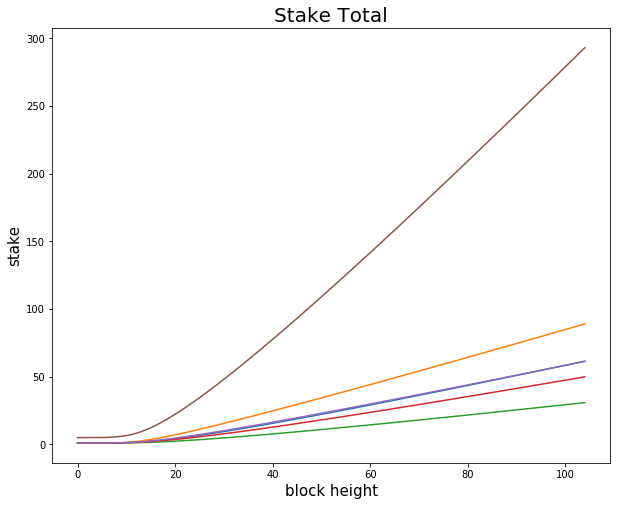

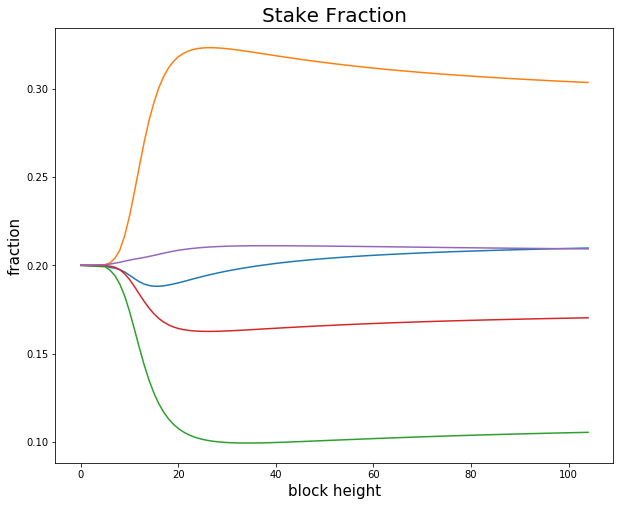

In [288]:
# # Out-loop weights.
# M = np.array([[0,     0.1,   0.3,   0.1,     0], 
#               [0.1,   0,     0,     0.1,     0],
#               [0.1,   0.1,   0,     0.1,     0],
#               [0.2,   0,     0.3,     0,     0.5],
#               [0,     0.1,   0,     0.1,     0]])


# # In-loop weights.
# N = np.array([0.6, 
#               0.7,
#               0.4,
#               0.6,
#               0.5])


# edges = {'a': list(zip(['a', 'b', 'c', 'd'], [0.6, 0.1, 0.1, 0.2])),
#          'b': list(zip(['b', 'a', 'c', 'e'], [0.7, 0.1, 0.1, 0.1])),
#          'c': list(zip(['c', 'a', 'd'], [0.4, 0.3, 0.3])),
#          'd': list(zip(['d', 'a', 'b', 'c', 'e'], [0.6, 0.1, 0.1, 0.1, 0.1])),
#          'e': list(zip(['e', 'd'], [0.5, 0.5]))
# }

edges = {'a': list(zip(['a', 'b', 'c', 'd'], [0.6, 0.1, 0.1, 0.2])),
         'b': list(zip(['b'], [1.0])),
         'c': list(zip(['c', 'a', 'd'], [0.4, 0.3, 0.3])),
         'd': list(zip(['d', 'a', 'b', 'c'], [0.5, 0.2, 0.1, 0.2])),
         'e': list(zip(['e'], [1.0]))
}

# [trial] --> {id} --> ([block num], [stake])
data = []

for j in range(1):
    
    data.append(
        {
         'a': ([0],[1]),
         'b': ([0],[1]),
         'c': ([0],[1]),
         'd': ([0],[1]),
         'e': ([0],[1]),
         'total': ([0],[5]),
        }
    )
    
    b = Bittensor()
    for k in ['a', 'b', 'c', 'd', 'e']:
        b.subscribe(k)
        
    for k in ['a', 'b', 'c', 'd', 'e']:
        b.emit(k, edges[k], inc_height = False)
    
    for i in range(100):
        for k in ['a','b','c','d']:
            b.emit(k, edges[k], inc_height = False)
            data[j][k][1].append(b.stake[k])
            data[j][k][0].append(b.block_height)
            
        b.emit('e', edges['e'], inc_height = True)
        data[j]['e'][1].append(b.stake['e'])
        data[j]['e'][0].append(b.block_height-1)
        
        data[j]['total'][1].append(b.total)
        data[j]['total'][0].append(b.block_height-1)
        
            
    print ('Trial:', j, [v / sum(list(b.stake.values())) for v in list(b.stake.values())])
    
    
import matplotlib.pyplot as plt

for trial in data:
    
    # plot total stake.
    plt.figure(figsize=(10,8))
    plt.title('Stake Total', fontsize=20)
    plt.xlabel('block height', fontsize=15)
    plt.ylabel('stake', fontsize=15)
    plt.plot(trial['a'][0], trial['a'][1])
    plt.plot(trial['b'][0], trial['b'][1])
    plt.plot(trial['c'][0], trial['c'][1])
    plt.plot(trial['d'][0], trial['d'][1])
    plt.plot(trial['e'][0], trial['e'][1])
    plt.plot(trial['total'][0], trial['total'][1])
    
    # plot stake fraction.
    plt.figure(figsize=(10,8))
    plt.title('Stake Fraction', fontsize=20)
    plt.xlabel('block height', fontsize=15)
    plt.ylabel('fraction', fontsize=15)
    
    plt.plot(trial['a'][0], [a/b for a,b in list(zip(trial['a'][1], trial['total'][1]))])
    plt.plot(trial['b'][0], [a/b for a,b in list(zip(trial['b'][1], trial['total'][1]))])
    plt.plot(trial['c'][0], [a/b for a,b in list(zip(trial['c'][1], trial['total'][1]))])
    plt.plot(trial['d'][0], [a/b for a,b in list(zip(trial['d'][1], trial['total'][1]))])
    plt.plot(trial['e'][0], [a/b for a,b in list(zip(trial['e'][1], trial['total'][1]))])
    
    break

    